<img src="uva_seal.png">  


---
# DS5110 Team 3 Project Code
---
### Trey Briggs, Julie Crowe, Keenan Kunc
#### 25 February 2022
---

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col,isnan, when, count

# import data types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType


In [2]:
# context manager
spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master("local") \
        .appName("pspark_test") \
        .getOrCreate()

from pyspark.sql.functions import from_utc_timestamp
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import date_format
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import min, max
from pyspark.sql.functions import lag
from pyspark.sql.window import Window
from pyspark.sql.types import *

In [3]:
path = 'tweets.csv'

df = spark.read.\
    format("csv").\
    option("delimiter", ";").\
    option("header", "true").\
    option("inferSchema", "true").load(path)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- url: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- replies: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- retweets: string (nullable = true)
 |-- text: string (nullable = true)



In [4]:
df.show(10, False)

+-------------------+-------------+-------------------+----+----------------------+-------+-----+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                 |user         |fullname           |url |timestamp             |replies|likes|retweets|text                                                                                                                                                                                                                                  |
+-------------------+-------------+-------------------+----+----------------------+-------+-----+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Number of records  
 
Statistical summary of response variable  
Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)  
Note: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation.  
Include up to five helpful graphs  

In [5]:
#df.count()
#40152515

Number of columns 

In [6]:
len(df.columns)

9

Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)  
Note: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation.

In [7]:
#df.describe().show()
#df.describe(['retweets']).show()

In [8]:
#Counting null values in each column
#df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
#   ).show()
#+---+--------+--------+--------+---------+--------+--------+--------+--------+
#| id|    user|fullname|     url|timestamp| replies|   likes|retweets|    text|
#+---+--------+--------+--------+---------+--------+--------+--------+--------+
#|241|22830824|23174141|36862014| 23256898|23258305|23258743|23259423|23260368|
#+---+--------+--------+--------+---------+--------+--------+--------+--------+

In [9]:
cols = ['id', 'user', 'timestamp', 'replies', 'likes', 'retweets', 'text']

df2 = df.select(cols)

In [10]:
df_dropped = df2.na.drop()
df_dropped.cache()

DataFrame[id: string, user: string, timestamp: string, replies: string, likes: string, retweets: string, text: string]

In [11]:
df_dropped.show(10, False)

+-------------------+---------------+----------------------+-------+-----+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                 |user           |timestamp             |replies|likes|retweets|text                                                                                                                                                                                                                                  |
+-------------------+---------------+----------------------+-------+-----+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1132977055300300800|KamdemAbdiel   |2019-05-27 11:49:1

In [12]:
#df_dropped.count()
#16892858

In [13]:
path2 = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'

bit_price = spark.read.\
    format("csv").\
    option("delimiter", ",").\
    option("header", "true").\
    option("inferSchema", "true").load(path2)
bit_price.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [51]:
bit_price.tail(5)
#bit_price.columns

[Row(Timestamp=1617148560, Open=58714.31, High=58714.31, Low=58686.0, Close=58686.0, Volume_(BTC)=1.38448731, Volume_(Currency)=81259.372187, Weighted_Price=58692.753339, StdDate='2021-03-30'),
 Row(Timestamp=1617148620, Open=58683.97, High=58693.43, Low=58683.97, Close=58685.81, Volume_(BTC)=7.29484767, Volume_(Currency)=428158.14664, Weighted_Price=58693.226508, StdDate='2021-03-30'),
 Row(Timestamp=1617148680, Open=58693.43, High=58723.84, Low=58693.43, Close=58723.84, Volume_(BTC)=1.70568236, Volume_(Currency)=100117.07037, Weighted_Price=58696.198496, StdDate='2021-03-30'),
 Row(Timestamp=1617148740, Open=58742.18, High=58770.38, Low=58742.18, Close=58760.59, Volume_(BTC)=0.72041549, Volume_(Currency)=42332.958633, Weighted_Price=58761.866202, StdDate='2021-03-30'),
 Row(Timestamp=1617148800, Open=58767.75, High=58778.18, Low=58755.97, Close=58778.18, Volume_(BTC)=2.71283104, Volume_(Currency)=159417.751, Weighted_Price=58764.349363, StdDate='2021-03-31')]

In [15]:
bit_price = bit_price.withColumn("StdDate", from_unixtime(col("Timestamp"), format='yyyy-MM-dd'))

In [16]:
bit_price.show(5)
#Beginning timestamp: 1325317920--Beginning of Bitcoin Prices data
#End timestamp: 1574467200--End of Tweets data

+----------+----+----+----+-----+------------+-----------------+--------------+----------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|   StdDate|
+----------+----+----+----+-----+------------+-----------------+--------------+----------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31|
|1325317980| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31|
|1325318040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31|
|1325318100| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31|
|1325318160| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31|
+----------+----+----+----+-----+------------+-----------------+--------------+----------+
only showing top 5 rows



In [17]:
bit_price_filter = bit_price.filter((bit_price["Timestamp"] >= 1325317920) & (bit_price["Timestamp"] <= 1574467200))

In [18]:
bit_price_filter.show(5)

+----------+----+----+----+-----+------------+-----------------+--------------+----------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|   StdDate|
+----------+----+----+----+-----+------------+-----------------+--------------+----------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31|
|1325317980| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31|
|1325318040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31|
|1325318100| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31|
|1325318160| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31|
+----------+----+----+----+-----+------------+-----------------+--------------+----------+
only showing top 5 rows



In [19]:
bit_price_na_drop = bit_price_filter.na.drop()
price_grp = bit_price_na_drop.groupBy("StdDate").avg("Weighted_Price").sort("StdDate", ascending = True)

In [20]:
price_grp.show(5)

+----------+-------------------+
|   StdDate|avg(Weighted_Price)|
+----------+-------------------+
|2011-12-31|     4.471602874575|
|2012-01-01|  4.806666666666667|
|2012-01-02|                5.0|
|2012-01-03|             5.2525|
|2012-01-04|  5.208159313655556|
+----------+-------------------+
only showing top 5 rows



In [21]:
window = Window.orderBy("StdDate")
price_2day = price_grp.withColumn("PrevDayPrice", lag(col("avg(Weighted_Price)")).over(window))
price_diff = price_2day.withColumn("PriceDiff", col("avg(Weighted_Price)") - col("PrevDayPrice"))
price_diff.show(5)

+----------+-------------------+-----------------+--------------------+
|   StdDate|avg(Weighted_Price)|     PrevDayPrice|           PriceDiff|
+----------+-------------------+-----------------+--------------------+
|2011-12-31|     4.471602874575|             null|                null|
|2012-01-01|  4.806666666666667|   4.471602874575|  0.3350637920916668|
|2012-01-02|                5.0|4.806666666666667| 0.19333333333333336|
|2012-01-03|             5.2525|              5.0|  0.2525000000000004|
|2012-01-04|  5.208159313655556|           5.2525|-0.04434068634444...|
+----------+-------------------+-----------------+--------------------+
only showing top 5 rows



In [22]:
df_date = df_dropped.withColumn("StdDate", date_format(col("timestamp"), "yyyy-MM-dd"))
df_date = df_date.withColumn('UnixTimestamp', unix_timestamp(col('StdDate'), 'yyyy-MM-dd'))

In [23]:
df_date.show(5)

+-------------------+-------------+--------------------+-------+-----+--------+--------------------+----------+-------------+
|                 id|         user|           timestamp|replies|likes|retweets|                text|   StdDate|UnixTimestamp|
+-------------------+-------------+--------------------+-------+-----+--------+--------------------+----------+-------------+
|1132977055300300800| KamdemAbdiel|2019-05-27 11:49:...|      0|    0|       0|È appena uscito u...|2019-05-27|   1558915200|
|1132977073402736640|    bitcointe|2019-05-27 11:49:...|      0|    0|       0|Cardano: Digitize...|2019-05-27|   1558915200|
|1132977023893139456|    3eyedbran|2019-05-27 11:49:...|      0|    2|       1|Another Test twee...|2019-05-27|   1558915200|
|1132977089089556481|DetroitCrypto|2019-05-27 11:49:...|      0|    0|       0|Current Crypto Pr...|2019-05-27|   1558915200|
|1132977092340191232| mmursaleen72|2019-05-27 11:49:...|      0|    0|       0|Spiv (Nosar Baz):...|2019-05-27|   1558

In [24]:
#df_date.agg(min(df_date["UnixTimestamp"])).show()
bit_price.agg(min(bit_price["Timestamp"])).show()

+--------------+
|min(Timestamp)|
+--------------+
|    1325317920|
+--------------+



In [25]:
#df_date.agg(max(df_date["UnixTimestamp"])).show()
bit_price.agg(max(bit_price["Timestamp"])).show()

+--------------+
|max(Timestamp)|
+--------------+
|    1617148800|
+--------------+



In [26]:
df_time = df_date.filter((df_date["UnixTimestamp"] >= 1325317920) & (df_date["UnixTimestamp"] <= 1574467200))

In [27]:
#df_time.count()
#16889437

In [28]:
final_df = df_time.join(price_diff,df_time["StdDate"] == price_diff["StdDate"],"left")

In [29]:
final_df.show(5)

+------------------+---------------+--------------------+-------+-----+--------+--------------------+----------+-------------+----------+-------------------+-----------------+------------------+
|                id|           user|           timestamp|replies|likes|retweets|                text|   StdDate|UnixTimestamp|   StdDate|avg(Weighted_Price)|     PrevDayPrice|         PriceDiff|
+------------------+---------------+--------------------+-------+-----+--------+--------------------+----------+-------------+----------+-------------------+-----------------+------------------+
|312067116096438273|JamesVancePhoto|2013-03-14 04:06:...|      0|    0|       1|@Btc_ImFree mixta...|2013-03-14|   1363219200|2013-03-14|  47.36082563895725|46.22939937123764|1.1314262677196112|
|312316656590389248|     falloutkez|2013-03-14 20:37:...|      0|    0|       0|Ellen btc is at 5:00|2013-03-14|   1363219200|2013-03-14|  47.36082563895725|46.22939937123764|1.1314262677196112|
|312365399960346624|    m

In [30]:
cols_keep = ["id", "user", "timestamp", "replies", "likes", 'retweets', 'text', 'avg(Weighted_Price)', 'PriceDiff']
final = final_df.select(cols_keep)

In [31]:
final.show(5)

+------------------+---------------+--------------------+-------+-----+--------+--------------------+-------------------+------------------+
|                id|           user|           timestamp|replies|likes|retweets|                text|avg(Weighted_Price)|         PriceDiff|
+------------------+---------------+--------------------+-------+-----+--------+--------------------+-------------------+------------------+
|312067116096438273|JamesVancePhoto|2013-03-14 04:06:...|      0|    0|       1|@Btc_ImFree mixta...|  47.36082563895725|1.1314262677196112|
|312316656590389248|     falloutkez|2013-03-14 20:37:...|      0|    0|       0|Ellen btc is at 5:00|  47.36082563895725|1.1314262677196112|
|312365399960346624|    mtgoxtrades|2013-03-14 23:51:...|      0|    0|       0|Fri Mar 15 00:50:...|  47.36082563895725|1.1314262677196112|
|312294576759123968|      bcchanger|2013-03-14 19:10:...|      0|    0|       0|lamaestro wants t...|  47.36082563895725|1.1314262677196112|
|312172551017

In [32]:
#Getting number of tweets per user
final_cts = final.join(final.groupBy('user').count(),on='user')
final_cts.show(5)

+----------+-------------------+--------------------+-------+-----+--------+--------------------+-------------------+------------------+-----+
|      user|                 id|           timestamp|replies|likes|retweets|                text|avg(Weighted_Price)|         PriceDiff|count|
+----------+-------------------+--------------------+-------+-----+--------+--------------------+-------------------+------------------+-----+
|00845ltham|1184924483460780037|2019-10-17 20:09:...|      0|    0|       0|jsuis vraiment en...|  8032.837878443989|-31.68501935851691|    2|
|00845ltham|1188184882213801984|2019-10-26 20:05:...|      0|    0|       0|Ouaah bitcoin ça ...|  9318.768119687262|1438.1838009643898|    2|
|   00_Yaft|1176775324937252864|2019-09-25 08:27:...|      0|    0|       0|        👇🏽👇🏽👇🏽|  8448.935015594026|-974.2917063462974|    2|
|   00_Yaft|1176934240484769793|2019-09-25 18:59:...|      0|    0|       0|                #btc|  8448.935015594026|-974.2917063462974|    2|
| 021

In [33]:
# final_cts.describe(['replies', 'retweets', 'likes', 'PriceDiff', 'count']).show()
# +-------+------------------+------------------+------------------+-------------------+-----------------+
# |summary|           replies|          retweets|             likes|          PriceDiff|            count|
# +-------+------------------+------------------+------------------+-------------------+-----------------+
# |  count|          16889437|          16889437|          16889437|           16887859|         16889437|
# |   mean|0.3137957766146971|1.0478859656482333| 2.659858111315374|  6.223094560790429|7612.314038472686|
# | stddev| 23.17431338674726| 86.02979304290486|146.72037225951092|  359.3747394185532|19308.80896621983|
# |    min|                 0|                 0|                 0|-2462.9357976494157|                1|
# |    max|               997|               999|               999|  2197.128696507658|           146639|
# +-------+------------------+------------------+------------------+-------------------+-----------------+

In [34]:
ex_pt = final_cts.filter(col("text").contains("!"))
# ex_pt.describe(['replies', 'retweets', 'likes', 'PriceDiff', 'count']).show()
# +-------+------------------+------------------+------------------+-------------------+------------------+
# |summary|           replies|          retweets|             likes|          PriceDiff|             count|
# +-------+------------------+------------------+------------------+-------------------+------------------+
# |  count|           1647561|           1647561|           1647561|            1647498|           1647561|
# |   mean|0.5312986893960223|1.4996561584062744|3.0544793182164423|  13.56759761591313| 5785.459591480983|
# | stddev|18.117946848046035| 39.33543263630934| 57.47601852602754|   377.235885850461|15073.494239893986|
# |    min|                 0|                 0|                 0|-2462.9357976494157|                 1|
# |    max|                99|               997|               998|  2197.128696507658|            101531|
# +-------+------------------+------------------+------------------+-------------------+------------------+

In [35]:
hash_bitcoin = final_cts.filter(col("text").contains("#bitcoin"))
# hash_bitcoin.describe(['replies', 'retweets', 'likes', 'PriceDiff', 'count']).show()
# +-------+-------------------+------------------+------------------+-------------------+------------------+
# |summary|            replies|          retweets|             likes|          PriceDiff|             count|
# +-------+-------------------+------------------+------------------+-------------------+------------------+
# |  count|            2121253|           2121253|           2121253|            2120180|           2121253|
# |   mean|0.11580089692271502|0.5327846324790112| 1.058098208935945|   4.57758285454221|21571.610171912544|
# | stddev|  4.143313673401526|14.475278976438265|26.650636084847324|  325.4481611722995|  40856.9358708947|
# |    min|                  0|                 0|                 0|-2462.9357976494157|                 1|
# |    max|                 99|              9976|               998|  2197.128696507658|            146639|
# +-------+-------------------+------------------+------------------+-------------------+------------------+

In [36]:
hash_btc = final_cts.filter(col("text").contains("#btc"))
# hash_btc.describe(['replies', 'retweets', 'likes', 'PriceDiff', 'count']).show()
# +-------+------------------+------------------+------------------+-------------------+------------------+
# |summary|           replies|          retweets|             likes|          PriceDiff|             count|
# +-------+------------------+------------------+------------------+-------------------+------------------+
# |  count|            787775|            787775|            787775|             786958|            787775|
# |   mean|0.0805141061851417|0.4958433562882803|0.6458798514804354|  8.697840548513406|40052.697708101936|
# | stddev| 3.524918239461035| 13.66988899953724| 17.89481179433489|  314.0834627298498| 55962.71911495728|
# |    min|                 0|                 0|                 0|-2462.9357976494157|                 1|
# |    max|               986|                99|               994|  2197.128696507658|            146639|
# +-------+------------------+------------------+------------------+-------------------+------------------+

In [37]:
invest = final_cts.filter(col("text").contains("invest"))
# invest.describe(['replies', 'retweets', 'likes', 'PriceDiff', 'count']).show()
# +-------+------------------+-----------------+------------------+-------------------+------------------+
# |summary|           replies|         retweets|             likes|          PriceDiff|             count|
# +-------+------------------+-----------------+------------------+-------------------+------------------+
# |  count|            395359|           395359|            395359|             395357|            395359|
# |   mean|0.2274059778580986|1.041569813764199|3.1807572358287026| 0.8036899158951533|13327.341089996686|
# | stddev| 9.658301128918001|82.15536179882766| 316.1176802568857| 358.27007368248354| 31245.41349505049|
# |    min|                 0|                0|                 0|-2462.9357976494157|                 1|
# |    max|                99|               99|               995|  2197.128696507658|            101531|
# +-------+------------------+-----------------+------------------+-------------------+------------------+

In [38]:
crypto = final_cts.filter(col("text").contains("crypto"))
# crypto.describe(['replies', 'retweets', 'likes', 'PriceDiff', 'count']).show()
# +-------+-------------------+------------------+------------------+-------------------+-----------------+
# |summary|            replies|          retweets|             likes|          PriceDiff|            count|
# +-------+-------------------+------------------+------------------+-------------------+-----------------+
# |  count|            1739811|           1739811|           1739811|            1739804|          1739811|
# |   mean|0.20126266588727165|0.7322576992558387|1.6819987918227899|-0.7505818553041735|7745.753985921459|
# | stddev|  7.296289400027821| 18.90324752004964|54.058605752419396|  354.0277177146568|18613.70934615795|
# |    min|                  0|                 0|                 0|-2462.9357976494157|                1|
# |    max|                 99|                99|               998|  2197.128696507658|           101531|
# +-------+-------------------+------------------+------------------+-------------------+-----------------+

In [39]:
tweets50 = final_cts.filter(col("count") >= 50)
# tweets50.describe(['replies', 'retweets', 'likes', 'PriceDiff', 'count']).show()
# +-------+-------------------+------------------+------------------+-------------------+------------------+
# |summary|            replies|          retweets|             likes|          PriceDiff|             count|
# +-------+-------------------+------------------+------------------+-------------------+------------------+
# |  count|           12337431|          12337431|          12337431|           12335874|          12337431|
# |   mean|0.27678906573013456|0.8648335297680693|2.4810300458823233|   5.80792630727241| 10415.94499511284|
# | stddev|  6.948142969405009| 22.37967930854908|55.116161811569796|  344.0563124656468|21936.831876883487|
# |    min|                  0|                 0|                 0|-2462.9357976494157|                50|
# |    max|                 99|               998|               999|  2197.128696507658|            146639|
# +-------+-------------------+------------------+------------------+-------------------+------------------+

In [40]:
tweets5000 = final_cts.filter(col("count") >= 5000)
# tweets5000.describe(['replies', 'retweets', 'likes', 'PriceDiff', 'count']).show()
# +-------+--------------------+-------------------+-------------------+-------------------+------------------+
# |summary|             replies|           retweets|              likes|          PriceDiff|             count|
# +-------+--------------------+-------------------+-------------------+-------------------+------------------+
# |  count|             4251157|            4251157|            4251157|            4249723|           4251157|
# |   mean|0.012693015101535888|0.24101815105864122|0.22866292635157912|-0.8476888227391992|28211.138703416505|
# | stddev|  0.3823795654669439| 3.3306755854554586|  4.172856484413112|  314.8936794686189| 30170.12774067542|
# |    min|                   0|                  0|                  0|-2462.9357976494157|              5032|
# |    max|                  94|                 99|                 99|  2197.128696507658|            146639|
# +-------+--------------------+-------------------+-------------------+-------------------+------------------+

In [41]:
bit_gained = final_cts.filter(col("PriceDiff") > 0)
# bit_gained.describe(['replies', 'retweets', 'likes', 'PriceDiff', 'count']).show()
# +-------+------------------+------------------+------------------+--------------------+------------------+
# |summary|           replies|          retweets|             likes|           PriceDiff|             count|
# +-------+------------------+------------------+------------------+--------------------+------------------+
# |  count|           8212934|           8212934|           8212934|             8212934|           8212934|
# |   mean|0.3187524701890944|1.1136050770650294|2.8604715440304282|   247.8386738474149| 7556.159158225307|
# | stddev|14.944356945609007| 98.14263287295066|149.18307117719397|   294.1525331840422|19237.895366675388|
# |    min|                 0|                 0|                 0|1.615385588911166...|                 1|
# |    max|               996|               998|               999|   2197.128696507658|            146639|
# +-------+------------------+------------------+------------------+--------------------+------------------+

In [42]:
bit_lost = final_cts.filter(col("PriceDiff") < 0)
# bit_lost.describe(['replies', 'retweets', 'likes', 'PriceDiff', 'count']).show()
# +-------+------------------+------------------+------------------+--------------------+------------------+
# |summary|           replies|          retweets|             likes|           PriceDiff|             count|
# +-------+------------------+------------------+------------------+--------------------+------------------+
# |  count|           8674925|           8674925|           8674925|             8674925|           8674925|
# |   mean|0.3091585229843486|0.9857409718239639| 2.470384816007055|  -222.5250278786321| 7653.152449963544|
# | stddev|28.881729554046192| 72.73524854779512|144.36342265127973|  248.81695393549543|19336.524160333185|
# |    min|                 0|                 0|                 0| -2462.9357976494157|                 1|
# |    max|               997|               999|               999|-6.18533625317496...|            146639|
# +-------+------------------+------------------+------------------+--------------------+------------------+

In [43]:
bit_gained500 = final_cts.filter(col("PriceDiff") >= 500)
# bit_gained500.describe(['replies', 'retweets', 'likes', 'PriceDiff', 'count']).show()
# +-------+------------------+------------------+------------------+-----------------+------------------+
# |summary|           replies|          retweets|             likes|        PriceDiff|             count|
# +-------+------------------+------------------+------------------+-----------------+------------------+
# |  count|           1137966|           1137966|           1137966|          1137966|           1137966|
# |   mean|0.3753714961606937|1.4896455605879262| 4.017496129058338| 846.767060801361| 4369.758381181863|
# | stddev|11.497555295047414|183.27315671928412|234.97040070439323|304.9867888797106|12281.168052765248|
# |    min|                 0|                 0|                 0|501.3362509171857|                 1|
# |    max|                99|               998|               998|2197.128696507658|            146639|
# +-------+------------------+------------------+------------------+-----------------+------------------+

In [44]:
bit_lost500 = final_cts.filter(col("PriceDiff") <= -500)
# bit_lost500.describe(['replies', 'retweets', 'likes', 'PriceDiff', 'count']).show()
# +-------+------------------+------------------+------------------+-------------------+------------------+
# |summary|           replies|          retweets|             likes|          PriceDiff|             count|
# +-------+------------------+------------------+------------------+-------------------+------------------+
# |  count|           1266683|           1266683|           1266683|            1266683|           1266683|
# |   mean| 0.343106365207396|1.0701019907901188|2.9162079225820507| -738.5933551784783|  4931.12153474863|
# | stddev|10.239153992899563| 52.78424188284091|184.69658507893467|  175.9353590020144|12639.194242518604|
# |    min|                 0|                 0|                 0|-2462.9357976494157|                 1|
# |    max|                99|                99|               996| -500.9476200223944|            146639|
# +-------+------------------+------------------+------------------+-------------------+------------------+

In [47]:
pd_price_diff = price_diff.toPandas()
pd_price_diff

,StdDate,avg(Weighted_Price),PrevDayPrice,PriceDiff
0,2011-12-31,4.471603,NaN,NaN
1,2012-01-01,4.806667,4.471603,0.335064
2,2012-01-02,5.000000,4.806667,0.193333
3,2012-01-03,5.252500,5.000000,0.252500
4,2012-01-04,5.208159,5.252500,-0.044341
...,...,...,...,...
2877,2019-11-19,8115.508756,8378.876831,-263.368076
2878,2019-11-20,8098.433022,8115.508756,-17.075734
2879,2019-11-21,7847.416641,8098.433022,-251.016381
2880,2019-11-22,7341.804982,7847.416641,-505.611659


In [48]:
final_mo = final_cts.withColumn("month", date_format(col("timestamp"), "yyyy-MM"))

+----------+-------------------+--------------------+-------+-----+--------+--------------------+-------------------+------------------+-----+-------+
|      user|                 id|           timestamp|replies|likes|retweets|                text|avg(Weighted_Price)|         PriceDiff|count|  month|
+----------+-------------------+--------------------+-------+-----+--------+--------------------+-------------------+------------------+-----+-------+
|00845ltham|1184924483460780037|2019-10-17 20:09:...|      0|    0|       0|jsuis vraiment en...|  8032.837878443989|-31.68501935851691|    2|2019-10|
|00845ltham|1188184882213801984|2019-10-26 20:05:...|      0|    0|       0|Ouaah bitcoin ça ...|  9318.768119687262|1438.1838009643898|    2|2019-10|
|   00_Yaft|1176775324937252864|2019-09-25 08:27:...|      0|    0|       0|        👇🏽👇🏽👇🏽|  8448.935015594026|-974.2917063462974|    2|2019-09|
|   00_Yaft|1176934240484769793|2019-09-25 18:59:...|      0|    0|       0|                #btc|  8

In [74]:
final_mo1 = final_mo.withColumn("replies_int",col("replies").cast(IntegerType()))
final_mo2 = final_mo1.withColumn("likes_int",col("likes").cast(IntegerType()))
final_mo3 = final_mo2.withColumn("retweets_int",col("retweets").cast(IntegerType()))
final_mo3.show(5)

+----------+-------------------+--------------------+-------+-----+--------+--------------------+-------------------+------------------+-----+-------+-----------+---------+------------+
|      user|                 id|           timestamp|replies|likes|retweets|                text|avg(Weighted_Price)|         PriceDiff|count|  month|replies_int|likes_int|retweets_int|
+----------+-------------------+--------------------+-------+-----+--------+--------------------+-------------------+------------------+-----+-------+-----------+---------+------------+
|00845ltham|1184924483460780037|2019-10-17 20:09:...|      0|    0|       0|jsuis vraiment en...|  8032.837878443989|-31.68501935851691|    2|2019-10|          0|        0|           0|
|00845ltham|1188184882213801984|2019-10-26 20:05:...|      0|    0|       0|Ouaah bitcoin ça ...|  9318.768119687262|1438.1838009643898|    2|2019-10|          0|        0|           0|
|   00_Yaft|1176775324937252864|2019-09-25 08:27:...|      0|    0|   

In [84]:
grp_mo = final_mo3.groupBy("month").sum("replies_int", "likes_int", "retweets_int").sort("month", ascending = True)
grp_mo_avg = final_mo3.groupBy("month").avg("replies_int", "likes_int", "retweets_int").sort("month", ascending = True)

In [79]:
grp_mo_pd = grp_mo.toPandas()
grp_mo_pd

,month,sum(replies_int),sum(likes_int),sum(retweets_int)
0,2012-01,18,11,46
1,2012-02,29,6,58
2,2012-03,38,8,86
3,2012-04,28,24,145
4,2012-05,57,50,183
...,...,...,...,...
90,2019-07,709913,5462362,1940707
91,2019-08,583589,4609023,2107314
92,2019-09,538695,4313918,1827836
93,2019-10,489599,3915480,1472036


In [85]:
grp_mo_avg_pd = grp_mo_avg.toPandas()
grp_mo_avg_pd.head()

,month,avg(replies_int),avg(likes_int),avg(retweets_int)
0,2012-01,0.010676,0.006524,0.027284
1,2012-02,0.017069,0.003531,0.034138
2,2012-03,0.013390,0.002819,0.030303
3,2012-04,0.009669,0.008287,0.050069
4,2012-05,0.024101,0.021142,0.077378


<AxesSubplot:xlabel='month'>

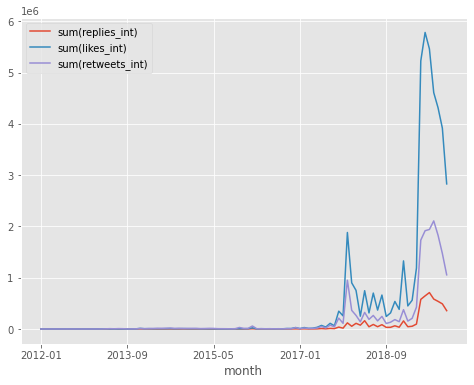

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

grp_mo_pd.plot(x='month', kind='line', figsize=(8,6))

<AxesSubplot:xlabel='month'>

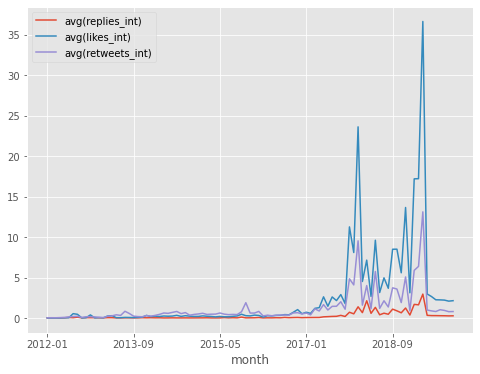

In [86]:
grp_mo_avg_pd.plot(x='month', kind='line', figsize=(8,6))

<AxesSubplot:xlabel='StdDate'>

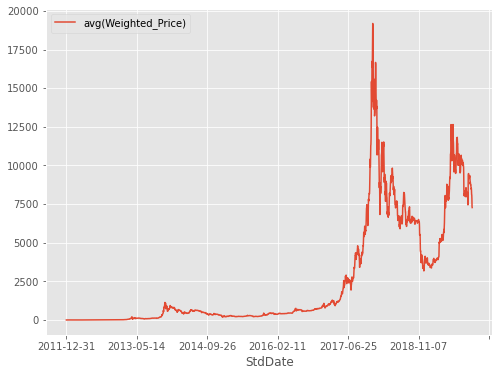

In [87]:
pd_price_diff.plot(x='StdDate', y='avg(Weighted_Price)', kind='line', figsize=(8,6))